$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 2: Ridge Regression with K-Fold Cross-Validation

*Sean Russell*

## Overview

In this assignment I modify the train function to accept a lambda for doing ridge regression and create a method that helps identify potentially useful lambdas when creating a new model.

### Python Implementation

Here is the new train method, the only difference being that it takes an argument for lambda and creates the model thusly.

In [1]:
import numpy as np

def train(X,T,lamb):
    means = X.mean(0)
    stds = X.std(0)
    n,d = X.shape
    Xs1 = np.insert( (X - means)/stds, 0, 1, axis=1)
    lambDiag = np.eye(d+1) * lamb
    lambDiag[0,0] = 0
    w = np.linalg.lstsq( Xs1.T @ Xs1 + lambDiag, Xs1.T @ T)[0]
    return {'w': w, 'means':means, 'stds':stds}

def use(X,model):
    Xs1 = np.insert((X-model['means'])/model['stds'], 0, 1, axis=1)
    return Xs1 @ model['w']

def rmse(A,B):
    return np.sqrt(np.mean( (A-B)**2 ))

And the partitionKFolds provided to us

In [2]:
def partitionKFolds(X,T,nFolds,shuffle=False,nPartitions=3):
    '''Usage: for Xtrain,Ttrain,Xval,Tval,Xtest,Ttext in partitionKFolds(X,T,5):'''
    # Randomly arrange row indices
    rowIndices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(rowIndices)
    # Calculate number of samples in each of the nFolds folds
    nSamples = X.shape[0]
    nEach = int(nSamples / nFolds)
    if nEach == 0:
        raise ValueError("partitionKFolds: Number of samples in each fold is 0.")
    # Calculate the starting and stopping row index for each fold.
    # Store in startsStops as list of (start,stop) pairs
    starts = np.arange(0,nEach*nFolds,nEach)
    stops = starts + nEach
    stops[-1] = nSamples
    startsStops = list(zip(starts,stops))
    # Repeat with testFold taking each single fold, one at a time
    for testFold in range(nFolds):
        if nPartitions == 3:
            # Repeat with validateFold taking each single fold, except for the testFold
            for validateFold in range(nFolds):
                if testFold == validateFold:
                    continue
                # trainFolds are all remaining folds, after selecting test and validate folds
                trainFolds = np.setdiff1d(range(nFolds), [testFold,validateFold])
                # Construct Xtrain and Ttrain by collecting rows for all trainFolds
                rows = []
                for tf in trainFolds:
                    a,b = startsStops[tf]                
                    rows += rowIndices[a:b].tolist()
                Xtrain = X[rows,:]
                Ttrain = T[rows,:]
                # Construct Xvalidate and Tvalidate
                a,b = startsStops[validateFold]
                rows = rowIndices[a:b]
                Xvalidate = X[rows,:]
                Tvalidate = T[rows,:]
                # Construct Xtest and Ttest
                a,b = startsStops[testFold]
                rows = rowIndices[a:b]
                Xtest = X[rows,:]
                Ttest = T[rows,:]
                # Return partition matrices, then suspend until called again.
                yield Xtrain,Ttrain,Xvalidate,Tvalidate,Xtest,Ttest,testFold
        else:
            # trainFolds are all remaining folds, after selecting test and validate folds
            trainFolds = np.setdiff1d(range(nFolds), [testFold])
            # Construct Xtrain and Ttrain by collecting rows for all trainFolds
            rows = []
            for tf in trainFolds:
                a,b = startsStops[tf]                
                rows += rowIndices[a:b].tolist()
            Xtrain = X[rows,:]
            Ttrain = T[rows,:]
            # Construct Xtest and Ttest
            a,b = startsStops[testFold]
            rows = rowIndices[a:b]
            Xtest = X[rows,:]
            Ttest = T[rows,:]
            # Return partition matrices, then suspend until called again.
            yield Xtrain,Ttrain,Xtest,Ttest,testFold

This multipleLambdas method does a whole bunch of partitioning of the data using the partitionKFolds from above and then tests our linear model using several lambdas for each different partitioning. Then it preserves the best lambda from each partition of data and returns that in a list with information on the errors.

In [3]:
def multipleLambdas(X, T, nFolds, lambdas=[0]):
    foldCount = 0
    results = []
    for Xtrain,Ttrain,Xval,Tval,Xtest,Ttest,_ in partitionKFolds(X,T,4,shuffle=True):
        for lamb in lambdas:
            model = train(Xtrain,Ttrain,lamb)
            predictTrain = use(Xtrain,model)
            errorTrain = rmse(Ttrain,predictTrain)
            predictVal = use(Xval,model)
            errorVal = rmse(Tval,predictVal)
            predictTest = use(Xtest,model)
            errorTest = rmse(Ttest,predictTest)
            result = [foldCount,lamb,errorTrain,errorVal,errorTest]
            results.append(result)
        foldCount += 1
    r = np.array(results)
    bestResults = []
    splitByFold = np.split(r,foldCount,axis=0)
    for fold in splitByFold:
        bestResults.append(fold[np.argmin(fold,axis=0)[3]])
    return np.array(bestResults)

## Data and Results

In my previous assignment, I used atmospheric data on a power plant to predict electric output provided by the UCI machine learning repository. The model for created by linear regression was very good and I think it is unlikely that ridge regression will do much better, but I am interested to see what happens. So, here I'm loading the data in from the spreadsheet.

In [4]:
import xlrd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

path = './CCPP/Folds5x2_pp.xlsx'
workbook = xlrd.open_workbook(path)

worksheet = workbook.sheet_by_index(0)
labels = ['Ambient Temperature (C)','Exhaust Steam (cm Hg)','Ambient Pressure (millibar)',
          'Relative Humidity (%)','Electrical Output (MW)']
data = np.zeros((worksheet.nrows-1,5))

for i in range(1,worksheet.nrows):
    for j in range(0,5):
        data[i-1][j] = float(worksheet.cell_value(i,j))

X = data[:,:4]
T = data[:,4,None]

And lets see what happens when we run the ridge regression a whole bunch of times...

In [5]:
results = multipleLambdas(X,T,4,range(0,50,2))
results = np.append(results,multipleLambdas(X,T,4,range(0,50,2)),axis=0)
results = np.append(results,multipleLambdas(X,T,4,range(0,50,2)),axis=0)
results = np.append(results,multipleLambdas(X,T,4,range(0,50,2)),axis=0)
results = np.append(results,multipleLambdas(X,T,4,range(0,50,2)),axis=0)
results = np.append(results,multipleLambdas(X,T,4,range(0,50,2)),axis=0)
results = np.append(results,multipleLambdas(X,T,4,range(0,50,2)),axis=0)
results = np.append(results,multipleLambdas(X,T,4,range(0,50,2)),axis=0)[:,1:]
results

array([[  0.        ,   4.57005925,   4.48658483,   4.6102319 ],
       [ 20.        ,   4.51152696,   4.6034522 ,   4.6116578 ],
       [ 16.        ,   4.54279161,   4.54134393,   4.60449449],
       [  0.        ,   4.57005925,   4.6102319 ,   4.48658483],
       [ 12.        ,   4.57280936,   4.60123713,   4.48703807],
       [  4.        ,   4.60068396,   4.54822129,   4.4871153 ],
       [  2.        ,   4.50948579,   4.61014635,   4.60514645],
       [  0.        ,   4.57208315,   4.48275581,   4.60186178],
       [ 26.        ,   4.54277942,   4.54779101,   4.60312124],
       [  2.        ,   4.54154193,   4.60365965,   4.54236827],
       [  0.        ,   4.60060548,   4.48573815,   4.54827915],
       [ 30.        ,   4.54382657,   4.60302046,   4.54786365],
       [  0.        ,   4.63955192,   4.55807486,   4.38733392],
       [  0.        ,   4.62550557,   4.58929851,   4.39154282],
       [ 20.        ,   4.57224317,   4.69577707,   4.38660298],
       [ 10.        ,   4

After running this a bunch of times, it seems as if the range of lambdas from 15 to 20 pops up with fair frequency, however it is rare to see anything much higher than this. Additionally, the range of error stays very consistent across train, validation, and testing data as well as across different folds, perhaps indicating that there are not many outliers in this dataset. Next, I try plotting the lambdas as a histogram to see if there are areas that contain good lambdas.

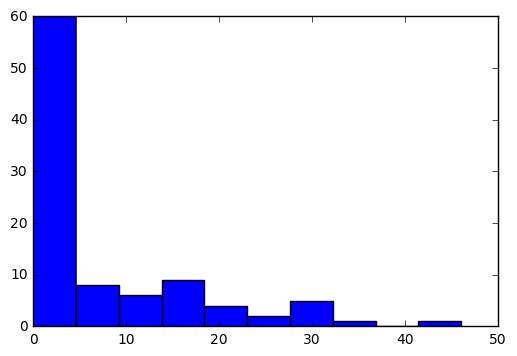

In [6]:
plt.hist(results[:,0]);

So my initial guess about low lambdas was more or less right. There are a couple outliers further out, but for the most part a good lambda would be less than five. However, maybe a good lambda is slightly above zero?

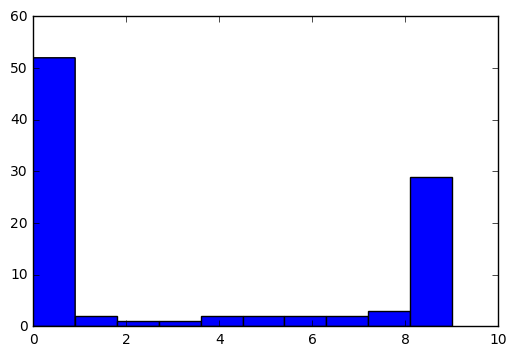

In [7]:
results = multipleLambdas(X,T,4,range(0,10))
results = np.append(results,multipleLambdas(X,T,4,range(0,10)),axis=0)
results = np.append(results,multipleLambdas(X,T,4,range(0,10)),axis=0)
results = np.append(results,multipleLambdas(X,T,4,range(0,10)),axis=0)
results = np.append(results,multipleLambdas(X,T,4,range(0,10)),axis=0)
results = np.append(results,multipleLambdas(X,T,4,range(0,10)),axis=0)
results = np.append(results,multipleLambdas(X,T,4,range(0,10)),axis=0)
results = np.append(results,multipleLambdas(X,T,4,range(0,10)),axis=0)[:,1:]
plt.hist(results[:,0]);

So running this cell a bunch of times reveals that the giant spike where lambda equals 9 is not a fluke. While it is still not quite as ideal as lambda equals 0, perhaps if upon new data being added the error was increasing, a lambda of 9 could be chosen. Next I wanted to see if plotting the various errors against the lambdas would be illuminating.

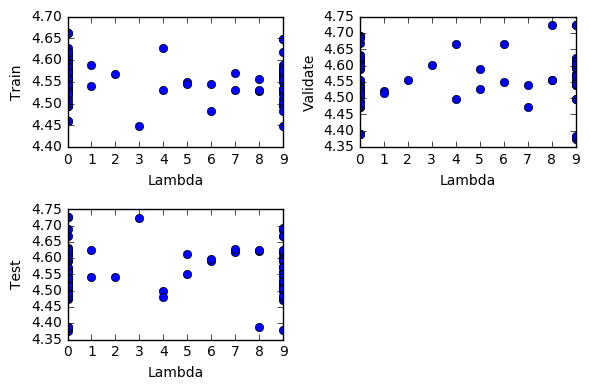

In [8]:
labels = ["Lambda","Train","Validate","Test"]

results = results[results[:, 0].argsort()]
for i in range(0,3):
    ax = plt.subplot(2,2, i+1)
    plt.plot(results[:,0],results[:,i+1],'o')
    plt.ylabel(labels[i+1])
    plt.xlabel(labels[0])
#    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    
    

plt.tight_layout()

Can't say this reveals any particular insights. No pattern is immediately evident from these graphs.

So, it seems like basic linear regression is all that is needed for this particular dataset. Perhaps a lambda of 9 could be selected if this model proves to lack resilience in the face of new data, but until then the old way is the best way

In [9]:
%run -i "A2grader.py"

 Testing:
X = np.arange(20).reshape((-1,1))
T = np.abs(X -10) + X
for Xtrain,Ttrain,Xval,Tval,Xtest,Ttest,_ in partitionKFolds(X,T,5,shuffle=False,nPartitions=3)
20/20 points. partitionKFolds produced 20 partitions. Correct.
10/10 points. Final training set contains 12 samples. Correct.
10/10 points. Final validation set contains 4 samples. Correct.
Testing:
X = np.linspace(0,100,1000).reshape((-1,1))
T = X * 0.1
results = multipleLambdas(X,T,4,range(0,10))
20/20 points. All best lambdas are 0.  Correct.
20/20 points. Mean of all train, validation and test errors for best lambda are correct.

cs480 Grade is 80/100
Up to 20 more points will be given based on the qualty of your descriptions of the method and the results.
